## 제10장 초해상

****공통 모듈 읽어들이기****

In [1]:
import os
import glob
import math
import random

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.python.keras.layers import Add, Input, Conv2D, Conv2DTranspose, Dense, Input, MaxPooling2D, UpSampling2D, Lambda

**예제 코드10.1:저해상도 이미지 생성**

In [2]:
def drop_resolution(x, scale=3.0):
    size = (x.shape[0], x.shape[1])
    small_size = (int(size[0]/scale), int(size[1]/scale))
    img = array_to_img(x)
    small_img = img.resize(small_size, 3)
    return img_to_array(small_img.resize(img.size, 3))

**예제 코드10.2:생성기 정의**

In [3]:
def data_generator(data_dir, mode, scale=2.0, target_size=(200, 200), batch_size=32, shuffle=True):
    for imgs in ImageDataGenerator().flow_from_directory(
        directory=data_dir,
        classes=[mode],
        class_mode=None,
        color_mode='rgb',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=shuffle
    ):
        x = np.array([
            drop_resolution(img, scale) for img in imgs
        ])
        yield x/255., imgs/255.

**예제 코드10.3:data_generator의 이용**

In [4]:
DATA_DIR = 'data/chap10/'  # train, test folder
N_TRAIN_DATA = 1000
N_TEST_DATA = 100
BATCH_SIZE = 32

train_data_generator = data_generator(DATA_DIR, 'train', batch_size=BATCH_SIZE)

test_x, test_y = next(
    data_generator(
        DATA_DIR,
        'test',
        batch_size=N_TEST_DATA,
        shuffle=False
    )
)

Found 100 images belonging to 1 classes.


**예제 코드10.4:SRCNN의 정의**

In [5]:
model = Sequential()
model.add(Conv2D(
    filters=64,
    kernel_size=9,
    padding='same',
    activation='relu',
    input_shape=(None, None, 3)
))
model.add(Conv2D(
    filters=32,
    kernel_size=1,
    padding='same',
    activation='relu'
))
model.add(Conv2D(
    filters=3,
    kernel_size=5,
    padding='same'
))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 64)    15616     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    2080      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 3)     2403      
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


**예제 코드10.5:최대 신호 대 잡음비(PSNR, Peak signal to noise ratio)의 정의**

In [6]:
# metric으로 사용할 함수
def psnr(y_true, y_pred):
    return -10*K.log(
        K.mean(K.flatten((y_true - y_pred))**2)
    )/np.log(10)

**예제 코드10.6:PSNR을 metrics에 지정하고 학습을 실행**

In [7]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam', 
    metrics=[psnr]
)

model.fit_generator(
    train_data_generator,
    validation_data=(test_x, test_y),
    steps_per_epoch=N_TRAIN_DATA//BATCH_SIZE,
    epochs=50
)

# 테스트 데이터에 적용
pred = model.predict(test_x)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Found 1000 images belonging to 1 classes.
Epoch 1/50
31/31 [==============================] - 5s 165ms/step - loss: 0.0418 - psnr: 15.2495 - val_loss: 0.0168 - val_psnr: 17.8967
Epoch 2/50
31/31 [==============================] - 3s 97ms/step - loss: 0.0120 - psnr: 19.2554 - val_loss: 0.0122 - val_psnr: 19.3279
Epoch 3/50
31/31 [==============================] - 3s 100ms/step - loss: 0.0086 - psnr: 20.6867 - val_loss: 0.0102 - val_psnr: 20.1355
Epoch 4/50
31/31 [==============================] - 3s 101ms/step - loss: 0.0075 - psnr: 21.2922 - val_loss: 0.0089 - val_psnr: 20.7878
Epoch 5/50
31/31 [==============================] - 3s 101ms/step - loss: 0.0066 - psnr: 21.8563 - val_loss: 0.0082 - val_psnr: 21.1834
Epoch 6/50
31/31 [==============================] - 3s 100ms/step

**그림10.6:정답 데이터（실행환경에 따라 조금씩 다를 수 있습니다）**

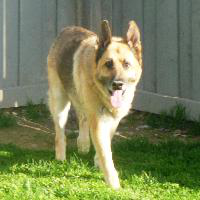

In [8]:
array_to_img(test_y[0])

**그림10.7:입력데이터**

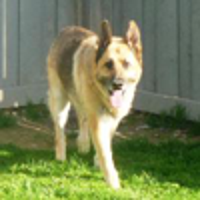

In [9]:
array_to_img(test_x[0])

**그림10.8:예측결과**

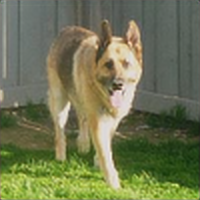

In [10]:
array_to_img(pred[0])

## CAE를 이용한 SRCNN

**예제 코드10.7:모델 구축 - CAE 구조에 skip connection 이용**

In [11]:
# 입력은 임의의 사이즈, 3 채널의 이미지
inputs = Input((None, None, 3), dtype='float')

# Endoder
conv1 = Conv2D(64, 3, padding='same')(inputs)
conv1 = Conv2D(64, 3, padding='same')(conv1)

conv2 = Conv2D(64, 3, strides=2, padding='same')(conv1)
conv2 = Conv2D(64, 3, padding='same')(conv2)

conv3 = Conv2D(64, 3, strides=2, padding='same')(conv2)
conv3 = Conv2D(64, 3, padding='same')(conv3)

# Decoder
deconv3 = Conv2DTranspose(64, 3, padding='same')(conv3)
deconv3 = Conv2DTranspose(64, 3, strides=2, padding='same')(deconv3)

# Add() 레이어를 사용해서 스킵 연결 구현
merge2 = Add()([deconv3, conv2])
deconv2 = Conv2DTranspose(64, 3, padding='same')(merge2)
deconv2 = Conv2DTranspose(64, 3, strides=2, padding='same')(deconv2)

merge1 = Add()([deconv2, conv1])
deconv1 = Conv2DTranspose(64, 3, padding='same')(merge1)
deconv1 = Conv2DTranspose(3, 3, padding='same')(deconv1)

output = Add()([deconv1, inputs])

model = Model(inputs, output)

**PSNR을metrics에 지정해서 학습 실행**

In [12]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam', 
    metrics=[psnr]
)

model.fit_generator(
    train_data_generator,
    validation_data=(test_x, test_y),
    steps_per_epoch=N_TRAIN_DATA//BATCH_SIZE,
    epochs=50
)

# 테스트 데이터로 적용
pred = model.predict(test_x)

Epoch 1/50
31/31 [==============================] - 8s 262ms/step - loss: 0.0502 - psnr: 19.3986 - val_loss: 0.0062 - val_psnr: 22.4349
Epoch 2/50
31/31 [==============================] - 5s 165ms/step - loss: 0.0042 - psnr: 23.7975 - val_loss: 0.0054 - val_psnr: 23.0787
Epoch 3/50
31/31 [==============================] - 5s 165ms/step - loss: 0.0038 - psnr: 24.3296 - val_loss: 0.0052 - val_psnr: 23.2575
Epoch 4/50
31/31 [==============================] - 5s 165ms/step - loss: 0.0038 - psnr: 24.3621 - val_loss: 0.0051 - val_psnr: 23.3695
Epoch 5/50
31/31 [==============================] - 5s 166ms/step - loss: 0.0037 - psnr: 24.4316 - val_loss: 0.0052 - val_psnr: 23.2152
Epoch 6/50
31/31 [==============================] - 5s 166ms/step - loss: 0.0037 - psnr: 24.4164 - val_loss: 0.0050 - val_psnr: 23.4594
Epoch 7/50
31/31 [==============================] - 5s 166ms/step - loss: 0.0036 - psnr: 24.5288 - val_loss: 0.0049 - val_psnr: 23.5039
Epoch 8/50
31/31 [==============================

**그림10.10:정답데이터**

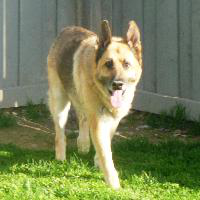

In [13]:
array_to_img(test_y[0])

**그림10.11:입력데이터**

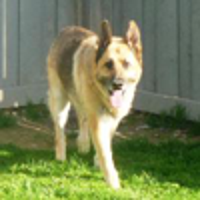

In [14]:
array_to_img(test_x[0])

**그림10.12:예측결과**

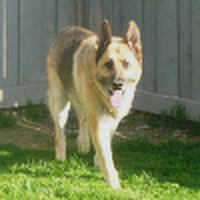

In [15]:
array_to_img(pred[0])